In [ ]:
import torch
from torch import nn
import torchvision 
from torchvision import transforms

In [ ]:
model = torchvision.models.resnet34(pretrained=True)
model.eval();

In [ ]:
import einops
import matplotlib.pyplot as plt

def imshow(img, figsize=(6, 6)):
    plt.figure(figsize=figsize)
    if len(img.shape) == 4:
        img = img.squeeze(0)
    img_reshaped = einops.rearrange(img, 'c w h -> w h c')
    plt.imshow(img_reshaped.detach())
    plt.xticks([])
    plt.yticks([])


In [ ]:
TFORM = transforms.Compose([
    transforms.Pad(12),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.RandomAffine(
        degrees=10, translate=(0.05, 0.05), scale=(1.2, 1.2), shear=10
    ),
])

In [ ]:
class pixelImage(nn.Module):
    def __init__(self):
        super().__init__()
        self.image = nn.Parameter(torch.rand(1, 3, 224, 224))
    
    def forward(self):
        return torch.clip(self.image, min=0.0, max=1.0)
    
class decorrImage(nn.Module):
    def __init__(self, scale=1.0, sigmoid=False):
        super().__init__()
        self.image = nn.Parameter(torch.rand(1, 3, 224, 224))
        projection = torch.Tensor(
            [[0.26, 0.09, 0.02],
             [0.27, 0.00, -0.05],
             [0.27, -0.09, 0.03]])
        self.register_buffer('projection', projection)
        self.scale = scale
        self.sigmoid = sigmoid
    
    def forward(self):
        image = torch.einsum('bchw, Cc -> bChw', self.image, self.projection)
        if self.sigmoid:
            return torch.clip(image * self.scale + 0.5, min=0.0, max=1.0)
        else:
            return torch.sigmoid(image * self.scale + 0.5)
    
class sigmoidImage(nn.Module):
    def __init__(self):
        super().__init__()
        self.image = nn.Parameter(torch.randn(1, 3, 224, 224))
    
    def forward(self):
        return self.image.sigmoid()
    
class badFourierImage(nn.Module):
    def __init__(self, scale=1.0):
        super().__init__()
        self.freq = nn.Parameter(torch.randn(1, 3, 224, 113, 2))
        self.scale = scale
        
    def forward(self):
        image = torch.fft.irfft2(torch.view_as_complex(self.freq))
        return torch.clip(image * self.scale + 0.5, min=0.0, max=1.0)
    
class fourierImage(nn.Module):
    def __init__(self, scale=1.0, sigmoid=False, learnable_scale=False):
        super().__init__()
        self.freq = nn.Parameter(torch.randn(1, 3, 224, 113, 2))
        H, W = self.freq.shape[2:4]
        freq_magnitude = (torch.fft.fftfreq(H)[:,None]**2 + torch.fft.fftfreq(W)**2).sqrt()
        freq_magnitude[0, 0] = 1/H
        self.register_buffer('freq_magnitude', freq_magnitude)
        if learnable_scale:
            self.scale = nn.Parameter(torch.Tensor([scale]))
        else:
            self.scale = scale
        self.sigmoid = sigmoid
        
    def forward(self):        
        image = torch.fft.irfft2(torch.view_as_complex(self.freq) / self.freq_magnitude)
        image = image * self.scale + 0.5
        if self.sigmoid:
            return image.sigmoid()
        else:
            return torch.clip(image, min=0.0, max=1.0)
        
class decorrFourierImage(nn.Module):
    def __init__(self, scale=1.0, sigmoid=False):
        super().__init__()
        self.freq = nn.Parameter(torch.randn(1, 3, 224, 113, 2))
        H, W = self.freq.shape[2:4]
        freq_magnitude = (torch.fft.fftfreq(H)[:,None]**2 + torch.fft.fftfreq(W)**2).sqrt()
        freq_magnitude[0, 0] = 1/H
        self.register_buffer('freq_magnitude', freq_magnitude)
        self.scale = scale
        self.sigmoid = sigmoid
        projection = torch.Tensor(
            [[0.26, 0.09, 0.02],
             [0.27, 0.00, -0.05],
             [0.27, -0.09, 0.03]])
        self.register_buffer('projection', projection)
        
    def forward(self):        
        image = torch.fft.irfft2(torch.view_as_complex(self.freq) / self.freq_magnitude)
        image = torch.einsum('bchw, Cc -> bChw', image, self.projection)
        image = image * self.scale + 0.5
        if self.sigmoid:
            return image.sigmoid()
        else:
            return torch.clip(image, min=0.0, max=1.0)        

In [ ]:
def optimize_img(img, model, lr=0.05, n_epochs=200, class_id=50, apply_transforms=False):
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    img = img.to(DEVICE)
    model = model.to(DEVICE)

    opt = torch.optim.Adam(img.parameters(), lr=lr)

    for i in range(n_epochs):
        opt.zero_grad()
        image = img()
        if apply_transforms:
            image = TFORM(image)
        loss = -model(image)[0, class_id]
        loss.backward()
        opt.step()

    imshow(img().cpu())

# Logit optimization

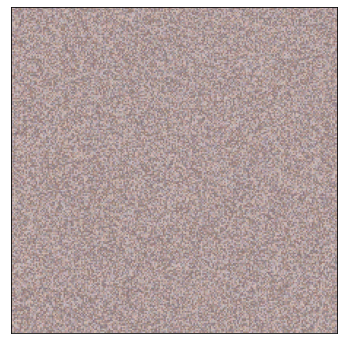

In [ ]:
img = decorrImage(scale=1.0, sigmoid=True)
imshow(img())

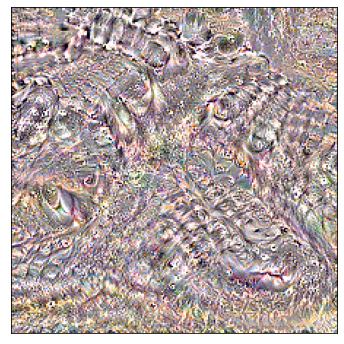

In [ ]:
optimize_img(img, model, apply_transforms=True, n_epochs=200)

## Fourier

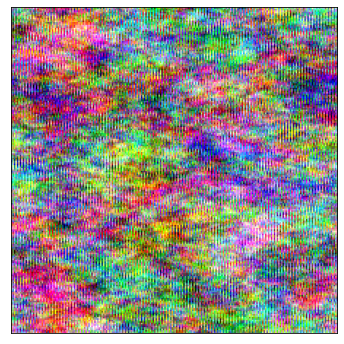

In [ ]:
img = fourierImage(scale=10, sigmoid=False)
imshow(img())

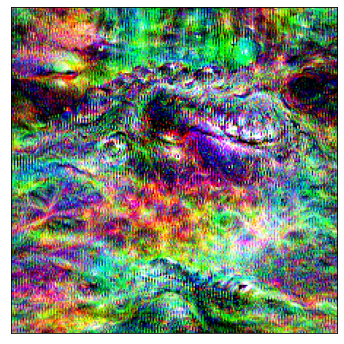

In [ ]:
optimize_img(img, model, apply_transforms=True)

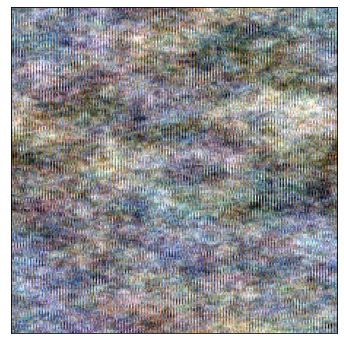

In [ ]:
img = decorrFourierImage(scale=20)
imshow(img())

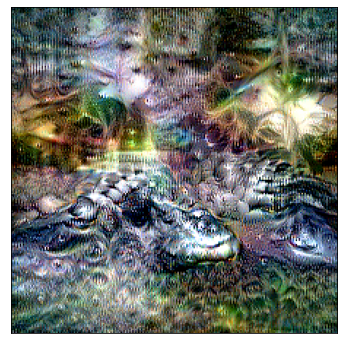

In [ ]:
optimize_img(img, model, apply_transforms=True, n_epochs=300)

# Inner neuron optimization

In [23]:
class SaveOutput:
    def __init__(self):
        self.output = None
        
    def __call__(self, module, module_in, module_out):
        self.output = module_out
        
    def clear(self):
        self.output = None    

def optimize_img_inner(img, model, relu_id, channel_id, lr=0.05, n_epochs=200, apply_transforms=False):
    # optimizes an image to activate some intermediate-layer channel of post-ReLU activation
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    img = img.to(DEVICE)
    model = model.to(DEVICE)
    opt = torch.optim.Adam(img.parameters(), lr=lr)
    
    post_relu = []
    for i, m in enumerate(model.modules()):
        if isinstance(m, nn.ReLU):
            hook = SaveOutput()
            post_relu.append(hook)
            m.register_forward_hook(hook)
        
    for i in range(n_epochs):
        opt.zero_grad()
        image = img()
        if apply_transforms:
            image = TFORM(image)
            
        for hook in post_relu:
            hook.clear()
        model(image)
            
        loss = -(post_relu[relu_id].output[0, channel_id] **2).sum()
        loss.backward()
        opt.step()

    imshow(img().cpu())

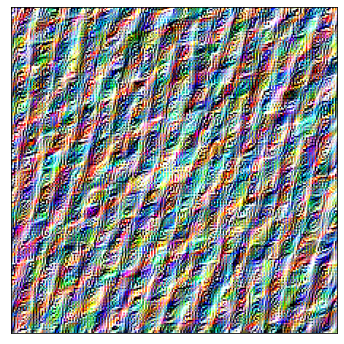

In [25]:
img = decorrFourierImage(scale=25.0)
optimize_img_inner(img, model, relu_id=4, channel_id=4, n_epochs=400)